# Plot modulated rate trajectories

Push of the past / pull of the present

In [34]:
import numpy as np
from bdms import poisson
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

import my_bdms
import modulators

In [35]:
with open('plot_settings.yml', 'r') as file:
    config = yaml.safe_load(file)

for key, value in config['paper']['rcParams'].items():
    plt.rcParams[key] = value

legend_info = config['paper']['legend_info']
legend_labels = legend_info['legend_labels']
fig_dpi = config['paper']['fig_dpi']
palette = sns.color_palette(legend_info['sns_palette'], len(legend_info['mode_order']))

We define a 2-state process with the two states having different birth rates, similar death rates, and similar mutation rates.
We take the sampling probability to be $0.1$.

In [36]:
modulator = modulators.FEModulator(
    state_space=np.array([0, 1]),
    birth_rates=np.array([0.25, 1.0]),
    death_rates=np.array([0.25, 0.25]),
    mutation_rates=np.array([0.5, 0.5]),
    transition_matrix=np.array([[0, 1], [1, 0]]),
    rhos=0.1 * np.ones(2),
    t_min=0.0,
    t_max=10.0,
    dt=0.01,
)
FE_birth_process = my_bdms.CustomProcess(modulator.λ, modulator.Λ, modulator.Λ_inv)
FE_death_process = poisson.ConstantProcess(0.0)
FE_mutation_process = my_bdms.CustomProcess(modulator.m, modulator.M, modulator.M_inv)

In [37]:
t = np.arange(modulator.t_min, modulator.t_max + modulator.dt, modulator.dt)

Note that we reverse the time direction to align with manuscript notation.

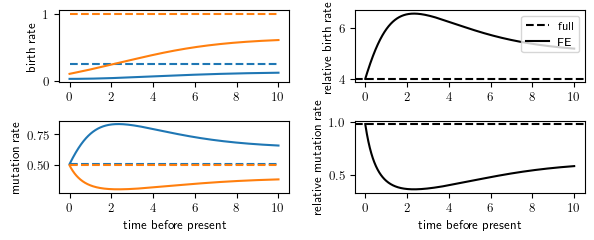

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(6, 2.5))

for state, state_label in zip(modulator.state_space, ("low fitness", "high fitness")):
    axes[0, 0].plot([modulator.t_min, modulator.t_max],
                 [modulator.birth_rates[state]] * 2,
                    color=f"C{state}", linestyle="--",
                    label=f"{state_label}, full")
    FE_birth_rate_trajectory = [FE_birth_process.λ(state, ti) for ti in t]
    axes[0, 0].plot(modulator.t_max - t, FE_birth_rate_trajectory,
                 label=f"{state_label}, FE", color=f"C{state}")
    axes[1, 0].plot([modulator.t_min, modulator.t_max],
                 [modulator.mutation_rates[state]] * 2,
                    color=f"C{state}", linestyle="--",
                    label=f"{state_label}, full")
    FE_mutation_rate_trajectory = [FE_mutation_process.λ(state, ti) for ti in t]
    axes[1, 0].plot(modulator.t_max - t, FE_mutation_rate_trajectory,
                 label=f"{state_label}, FE", color=f"C{state}")

axes[0, 0].set_ylabel("birth rate")
axes[0, 0].legend(loc='upper left', bbox_to_anchor=(0, .95))
            #    fontsize="small")
# Legend
handles = axes[0, 0].get_legend().legend_handles
labels = [text.get_text() for text in axes[0, 0].get_legend().get_texts()]
axes[0, 0].get_legend().remove()  # Remove the legend from the current plot, but keep the plot itself

axes[1, 0].set_xlabel("time before present")
axes[1, 0].set_ylabel("mutation rate")

axes[0, 1].axhline(modulator.birth_rates[1] / modulator.birth_rates[0], linestyle="--", color="k", label="full")
FE_relative_birth_rate_trajectory = [FE_birth_process.λ(1, ti) / FE_birth_process.λ(0, ti) for ti in t]
axes[0, 1].plot(modulator.t_max - t, FE_relative_birth_rate_trajectory, label=f"FE", color="k")
axes[0, 1].set_ylabel("relative birth rate")
axes[0, 1].legend(loc='upper right', fontsize="small")

axes[1, 1].axhline(modulator.mutation_rates[1] / modulator.mutation_rates[0], linestyle="--", color="k")
FE_relative_mutation_rate_trajectory = [FE_mutation_process.λ(1, ti) / FE_mutation_process.λ(0, ti) for ti in t]
axes[1, 1].plot(modulator.t_max - t, FE_relative_mutation_rate_trajectory, color="k")
axes[1, 1].set_ylabel("relative mutation rate")
axes[1, 1].set_xlabel("time before present")

plt.tight_layout()
plt.savefig("fig/POTP.pdf")
plt.show()

In [40]:
%%capture

# Change labels to desired labels
# labels = [legend_info['legend_labels'][label] for label in labels]
# Create a new figure just for the legend
legend_fig, legend_ax = plt.subplots(figsize=(2.5, .1))  # Create a new subplot
# Add the legend to the subplot
legend_ax.legend(handles, labels, loc='center', ncol = len(labels))
legend_ax.axis('off')  # Turn off the axis

# Draw the legend figure canvas before saving or showing
legend_fig.canvas.draw()
plt.tight_layout()

# Save the legend to a file
plt.savefig('fig/POTP_legend.pdf', bbox_inches='tight')